In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('/Users/TimothyW/Fun/cricket_prediction/data/processed_first_innings/first_innings_processed.parquet')

In [8]:
df = df[~((df.total_balls_bowled < 300) & (df.total_wickets_lost < 10))]


In [13]:
df['batting_team_balls_faced'] = df.groupby('batting_team')['batter'].transform('count')

In [4]:
df['batter_won_toss'] = (df['batting_team'] == df['toss_winner'])

In [5]:
def determine_bowl_team(row):
    if row['batting_team'] == row['team_one']:
        return row['team_two']
    return row['team_one']

In [6]:
df['bowling_team'] = df.apply(determine_bowl_team, axis=1)

In [7]:
df['year'] = df['date'].str[0:4]

In [18]:
df['match_id'] = df['city'] + df['batting_team'] + df['bowling_team'] + df['date']

/var/folders/v3/nvp5qny9761b98yy3p9n041h0000gq/T/ipykernel_70518/2705827292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['match_id'] = df['city'] + df['batting_team'] + df['bowling_team'] + df['date']


In [23]:
df['match_id'].value_counts()

DublinPakistanIreland2013-07-17                    326
LondonSri LankaEngland2006-06-17                   326
ChandigarhIndiaPakistan2007-11-08                  324
PeshawarIndiaPakistan2004-03-19                    323
PerthNew ZealandEngland2007-01-30                  323
                                                  ... 
PotchefstroomSouth AfricaPakistan2019-05-06        142
ChittagongWest IndiesBangladesh2011-10-18          134
NottinghamPakistanWest Indies2019-05-31            134
MirpurBangladeshWest Indies2011-03-04              115
KirtipurUnited States of AmericaNepal2020-02-12     73
Name: match_id, Length: 1859, dtype: int64

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644606 entries, 0 to 299
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   over_n                    644606 non-null  int64  
 1   batter                    644606 non-null  object 
 2   bowler                    644606 non-null  object 
 3   non_striker               644606 non-null  object 
 4   batter_runs               644606 non-null  int64  
 5   extras_runs               644606 non-null  int64  
 6   total_delivery_runs       644606 non-null  int64  
 7   wicket_player_out         17550 non-null   object 
 8   wicket_kind               17550 non-null   object 
 9   wicket_taken              644606 non-null  bool   
 10  over_ball_n               644606 non-null  int64  
 11  over_fractional           644606 non-null  float64
 12  overall_ball_fraction     644606 non-null  float64
 13  batting_team              644606 non-null  obje

<AxesSubplot:xlabel='current_wickets', ylabel='first_innings_total_runs'>

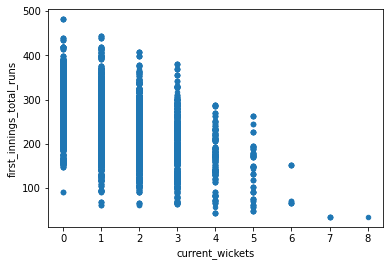

In [12]:
df[df.over_n == 10].plot.scatter('current_wickets', 'first_innings_total_runs')

In [16]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [14]:
df = df[~df.city.isna()]

In [147]:
features = ["current_runs", "current_wickets", "overall_ball_n", "batting_team","batter_won_toss"]
target = ["first_innings_total_runs"]

In [148]:
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['match_id'])
train_inds, test_inds = next(split)

In [149]:
train = df.iloc[train_inds]
test = df.iloc[test_inds]
X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]


In [150]:
#X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [151]:
from catboost import CatBoostRegressor

In [152]:
clf = CatBoostRegressor(learning_rate=0.03, iterations=3000, eval_metric='RMSE')

In [153]:
clf.fit(X_train, y_train, eval_set= (X_test, y_test), early_stopping_rounds=50, cat_features= [3,4])

0:	learn: 61.8027226	test: 65.3021414	best: 65.3021414 (0)	total: 57.8ms	remaining: 2m 53s
1:	learn: 61.0823485	test: 64.5540714	best: 64.5540714 (1)	total: 134ms	remaining: 3m 20s
2:	learn: 60.4022392	test: 63.8436204	best: 63.8436204 (2)	total: 199ms	remaining: 3m 18s
3:	learn: 59.7539171	test: 63.1614175	best: 63.1614175 (3)	total: 255ms	remaining: 3m 10s
4:	learn: 59.1111626	test: 62.4894752	best: 62.4894752 (4)	total: 311ms	remaining: 3m 6s
5:	learn: 58.5141966	test: 61.8517975	best: 61.8517975 (5)	total: 374ms	remaining: 3m 6s
6:	learn: 57.9211981	test: 61.2287065	best: 61.2287065 (6)	total: 432ms	remaining: 3m 4s
7:	learn: 57.3564308	test: 60.6318953	best: 60.6318953 (7)	total: 480ms	remaining: 2m 59s
8:	learn: 56.7985596	test: 60.0480963	best: 60.0480963 (8)	total: 532ms	remaining: 2m 56s
9:	learn: 56.2709877	test: 59.4998733	best: 59.4998733 (9)	total: 593ms	remaining: 2m 57s
10:	learn: 55.7644391	test: 58.9685086	best: 58.9685086 (10)	total: 661ms	remaining: 2m 59s
11:	learn:

41.74


In [90]:
preds = clf.predict(X_test)

In [91]:
flat_y_test = y_test.values.flatten()

In [92]:
residuals = preds - flat_y_test

In [93]:
import matplotlib.pyplot as plt

In [159]:
def plot_residuals(residuals, bins =40):
    fig = plt.figure()
    ax = fig.gca()
    ax.cla()
    ax.hist(residuals, bins = bins)
    return fig


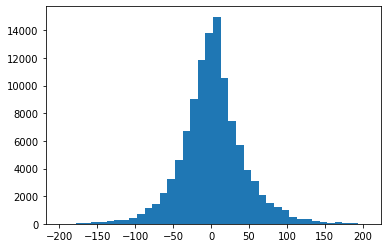

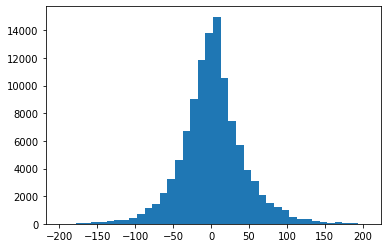

In [160]:
plot_residuals(residuals)

In [95]:
X_test['preds'] = preds
X_test['actual'] = y_test
X_test['residuals'] = preds - flat_y_test

/var/folders/v3/nvp5qny9761b98yy3p9n041h0000gq/T/ipykernel_70518/917844508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['preds'] = preds
/var/folders/v3/nvp5qny9761b98yy3p9n041h0000gq/T/ipykernel_70518/917844508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actual'] = y_test
/var/folders/v3/nvp5qny9761b98yy3p9n041h0000gq/T/ipykernel_70518/917844508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [96]:
from sklearn.metrics import mean_squared_error

In [97]:
import numpy as np

In [98]:
np.sqrt(mean_squared_error(y_test, preds))

41.907140228229245

In [99]:
X_test

,current_runs,current_wickets,overall_ball_n,preds,actual,residuals
0,0,0,0,246.461016,276,-29.538984
1,0,0,1,246.461016,276,-29.538984
2,0,0,2,246.461016,276,-29.538984
3,1,0,3,246.846156,276,-29.153844
4,1,0,4,246.846156,276,-29.153844
...,...,...,...,...,...,...
164,117,9,164,130.577840,117,13.577840
165,117,9,165,130.626204,117,13.626204
166,117,9,166,130.943218,117,13.943218
167,117,9,167,130.753063,117,13.753063


(array([ 2.,  6., 14., 51., 94., 79., 70., 37., 12.,  3.]),
 array([-121.54678873,  -98.10839836,  -74.67000799,  -51.23161762,
         -27.79322725,   -4.35483688,   19.08355349,   42.52194386,
          65.96033423,   89.3987246 ,  112.83711497]),
 <BarContainer object of 10 artists>)

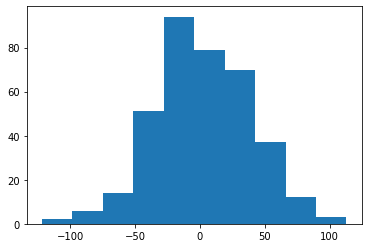

In [100]:
plt.hist(X_test[X_test.overall_ball_n == 150]['residuals'])

In [101]:
mid_way = X_test[X_test.overall_ball_n == 10]

In [102]:
mid_way

,current_runs,current_wickets,overall_ball_n,preds,actual,residuals
10,4,0,10,244.688674,276,-31.311326
10,7,0,10,254.198974,181,73.198974
10,10,1,10,241.213434,203,38.213434
10,0,0,10,237.230380,309,-71.769620
10,6,0,10,251.512974,375,-123.487026
...,...,...,...,...,...,...
10,1,0,10,239.098302,170,69.098302
10,14,0,10,277.670412,265,12.670412
10,13,0,10,276.624793,128,148.624793
10,4,0,10,244.688674,230,14.688674


In [103]:
np.sqrt(mean_squared_error(mid_way['actual'], mid_way['preds']))

66.40616222337655

In [104]:
def rmse_at_balls(test_df, balls):
    ball_df = test_df[test_df.overall_ball_n == balls]
    return np.sqrt(mean_squared_error(ball_df['actual'], ball_df['preds']))

In [105]:
rmse_at_balls(X_test, 11)

66.16754705566882

In [106]:
rmse_x = []
rmse_y = []
for i in range(12, 270):
    rmse_x.append(i)
    rmse_y.append(rmse_at_balls(X_test, i))


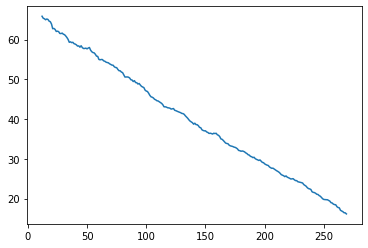

In [107]:
plt.plot(rmse_x, rmse_y)

In [108]:
def rmse_team(test_df, country):
    country_df = test_df[test_df.batting_team == country]
    return np.sqrt(mean_squared_error(country_df['actual'], country_df['preds']))

In [109]:
rmse_team(X_test, 'Sri Lanka')

AttributeError: 'DataFrame' object has no attribute 'batting_team'

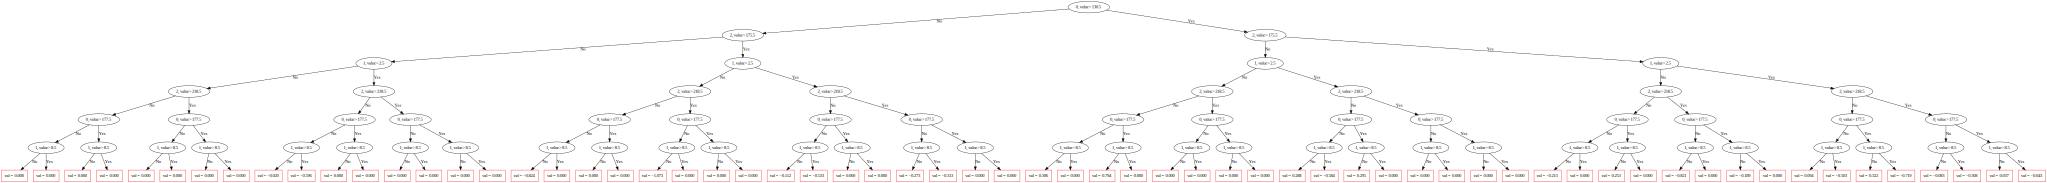

In [166]:
clf.plot_tree(200)